### Import all libraries

In [29]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import json
import os
import datetime
import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA
import math
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
import datetime
import matplotlib.dates as dates
import statsmodels.api as sm
from datetime import datetime

### Access the  database

In [30]:
credentials = service_account.Credentials.from_service_account_file(
'chain-coders-5d47d58b2c33.json')

project_id = 'chain-coders'
client = bigquery.Client(credentials= credentials,project=project_id)

datasets = client.list_datasets()
for dataset in datasets:
  did = dataset.dataset_id
  # Optional to verify that you are able to access the datasets.
  # The datasets we care about are mimiciii_clinical and mimiciii_notes.
  print(did)

redfin


## Using Pandas

In [31]:
query = """
    SELECT * FROM `redfin.redfin-data-county` 
"""

In [32]:
df = client.query(query).to_dataframe()

In [33]:
df.property_type_id.unique()

<IntegerArray>
[3, -1, 6, 13, 4]
Length: 5, dtype: Int64

In [34]:
df[['property_type_id','property_type']]

,property_type_id,property_type
0,3,Condo/Co-op
1,-1,All Residential
2,-1,All Residential
3,6,Single Family Residential
4,13,Townhouse
...,...,...
736022,3,Condo/Co-op
736023,4,Multi-Family (2-4 Unit)
736024,4,Multi-Family (2-4 Unit)
736025,3,Condo/Co-op


In [35]:
df_ppsf = df[['period_end','property_type_id','median_ppsf' ,'region' ]]

In [80]:
counties = df_ppsf.region.unique()
print('counties',counties)

counties ['Salem, VA' 'Hampton, VA' 'Norfolk, VA' ... 'Tallahatchie County, MS'
 'West Carroll Parish, LA' 'Collingsworth County, TX']


In [37]:
property_types = df_ppsf.property_type_id.unique()

In [38]:
property_types
#3  condo, 
#-1  all residential,
#6  single family,
#13 townhouse,
#4  multi family

<IntegerArray>
[3, -1, 6, 13, 4]
Length: 5, dtype: Int64

In [104]:
for county in counties[100:101]:
    print('county',county)
    mask1 = df['region'] ==county
    mask2 = df['property_type_id'] == 6
temp_county = county
        

county Hart County, GA


In [112]:
df_ppsf

,period_end,property_type_id,median_ppsf,region
0,2012-06-30,3,100.934829,"Salem, VA"
1,2013-05-31,-1,94.963369,"Salem, VA"
2,2014-11-30,-1,83.075671,"Salem, VA"
3,2014-10-31,6,94.683895,"Salem, VA"
4,2013-08-31,13,138.685457,"Salem, VA"
...,...,...,...,...
736022,2012-09-30,3,78.692494,"Fairbanks North Star Borough, AK"
736023,2021-02-28,4,158.173931,"Fairbanks North Star Borough, AK"
736024,2015-12-31,4,77.535714,"Fairbanks North Star Borough, AK"
736025,2015-06-30,3,74.634456,"Fairbanks North Star Borough, AK"


In [113]:
df_filtered = df_ppsf[mask1 & mask2]
df_filtered = df_filtered.set_index('period_end').sort_values(by=['period_end'])

df_filtered.index = pd.to_datetime(df_filtered.index)

df_filtered.index = df_filtered.index.to_period('M')

print('df_filtered',df_filtered)
print('temp_county',temp_county)

df_filtered             property_type_id  median_ppsf           region
period_end                                                
2012-01                    6    71.269575  Hart County, GA
2012-02                    6    60.443510  Hart County, GA
2012-03                    6    63.160608  Hart County, GA
2012-04                    6    66.298343  Hart County, GA
2012-05                    6    61.686587  Hart County, GA
...                      ...          ...              ...
2022-05                    6   191.427156  Hart County, GA
2022-06                    6   160.335653  Hart County, GA
2022-07                    6   175.932442  Hart County, GA
2022-08                    6   169.416152  Hart County, GA
2022-09                    6   178.516986  Hart County, GA

[129 rows x 3 columns]
temp_county Hart County, GA


In [114]:
arima_model = ARIMA(df_filtered.median_ppsf, order= (1,1,2))
model_fit = arima_model.fit ()
print (model_fit.summary ())

                               SARIMAX Results                                
Dep. Variable:            median_ppsf   No. Observations:                  129
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -534.846
Date:                Sat, 03 Dec 2022   AIC                           1077.693
Time:                        04:38:51   BIC                           1089.101
Sample:                    01-31-2012   HQIC                          1082.328
                         - 09-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6312      1.293     -0.488      0.625      -3.166       1.903
ma.L1         -0.0739      1.275     -0.058      0.954      -2.574       2.426
ma.L2         -0.4953      0.876     -0.566      0.5

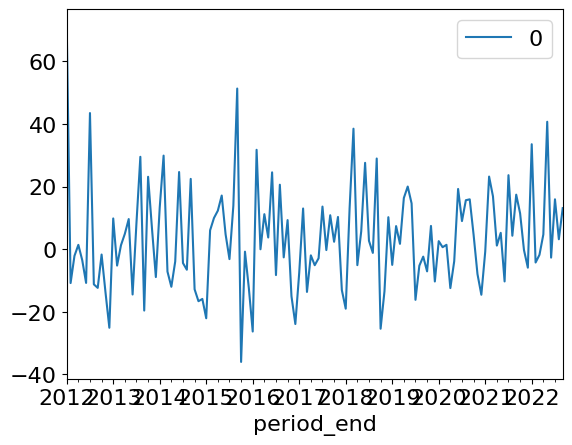

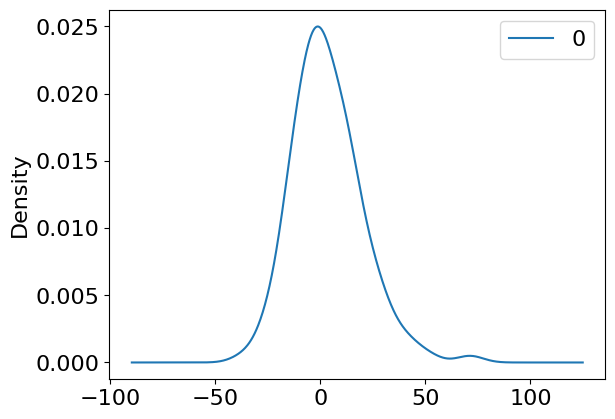

                0
count  129.000000
mean     3.522161
std     16.602515
min    -35.989105
25%     -7.148907
50%      1.379366
75%     13.037743
max     71.269575


In [115]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

[100.01445756]
[115.33884145]
[102.40210552]
[109.49017898]
[118.00926177]
[122.17817516]
[120.52941231]
[117.43094562]
[113.08052865]
[114.41083031]
[117.69680897]
[108.15912495]
[113.42076091]
[110.55676688]
[112.09619074]
[111.52143178]
[107.68529326]
[111.8004346]
[114.82741947]
[124.13394194]
[123.73439546]
[126.37850846]
[128.26491592]
[120.5292592]
[119.95819444]
[126.57869826]
[131.35693768]
[132.4805514]
[131.0970721]
[126.5600308]
[140.23158441]
[136.62670794]
[144.86712947]
[144.76916231]
[143.26162964]
[146.82420394]
[151.75518007]
[150.44959631]
[156.85168519]
[149.59281725]
[158.73729215]
[165.60147667]
[170.42581749]
[164.54582046]
Test RMSE: 13.921
period_end
2019-02    112.000000
2019-03    108.823645
2019-04    123.401712
2019-05    132.142857
2019-06    131.661294
2019-07    104.812941
2019-08    110.452586
2019-09    112.914795
2019-10    107.058824
2019-11    119.875549
2019-12    104.434907
2020-01    113.834423
2020-02    113.453370
2020-03    113.769227
2020-04 

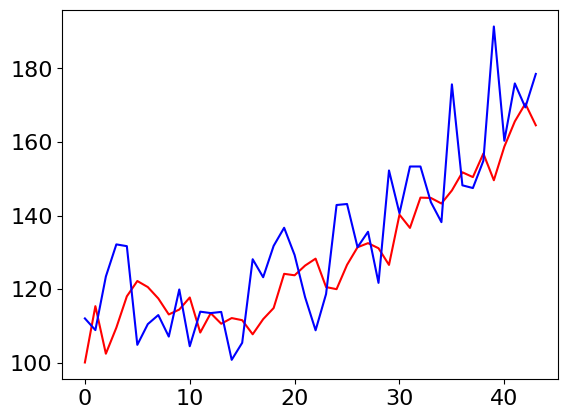

temp_county Hart County, GA


In [116]:
# split into train and test sets
X = df_filtered.median_ppsf
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
future = [x for x in test]
predictions = []
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    print(output)
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
print(test)
#plt.plot(test)

#my_xticks = 
#plt.xticks(x, my_xticks)

plt.plot(predictions, color='red')
plt.plot(  future , color='blue')

plt.show()
print('temp_county',temp_county)

In [117]:
print('mask1',mask1)
print('mask2',mask2)
#print('df_ppsf',df_ppsf)
df_sar = df_ppsf[mask1 & mask2]
df_sar = df_sar[['median_ppsf', 'period_end']]
df_sar = df_sar.set_index('period_end')
print('df_sar',df_sar)
df_sar.index = pd.to_datetime(df_sar.index)
ts = df_sar.resample('m').mean()
#print('ts',ts)

mask1 0         False
1         False
2         False
3         False
4         False
          ...  
736022    False
736023    False
736024    False
736025    False
736026    False
Name: region, Length: 736027, dtype: bool
mask2 0         False
1         False
2         False
3          True
4         False
          ...  
736022    False
736023    False
736024    False
736025    False
736026    False
Name: property_type_id, Length: 736027, dtype: boolean
df_sar             median_ppsf
period_end             
2014-02-28   101.644737
2013-11-30    76.439284
2015-04-30    81.528190
2017-03-31    76.473234
2015-05-31    89.927098
...                 ...
2012-02-29    60.443510
2012-04-30    66.298343
2012-09-30    56.381436
2012-07-31   104.330372
2012-08-31    63.333333

[129 rows x 1 columns]


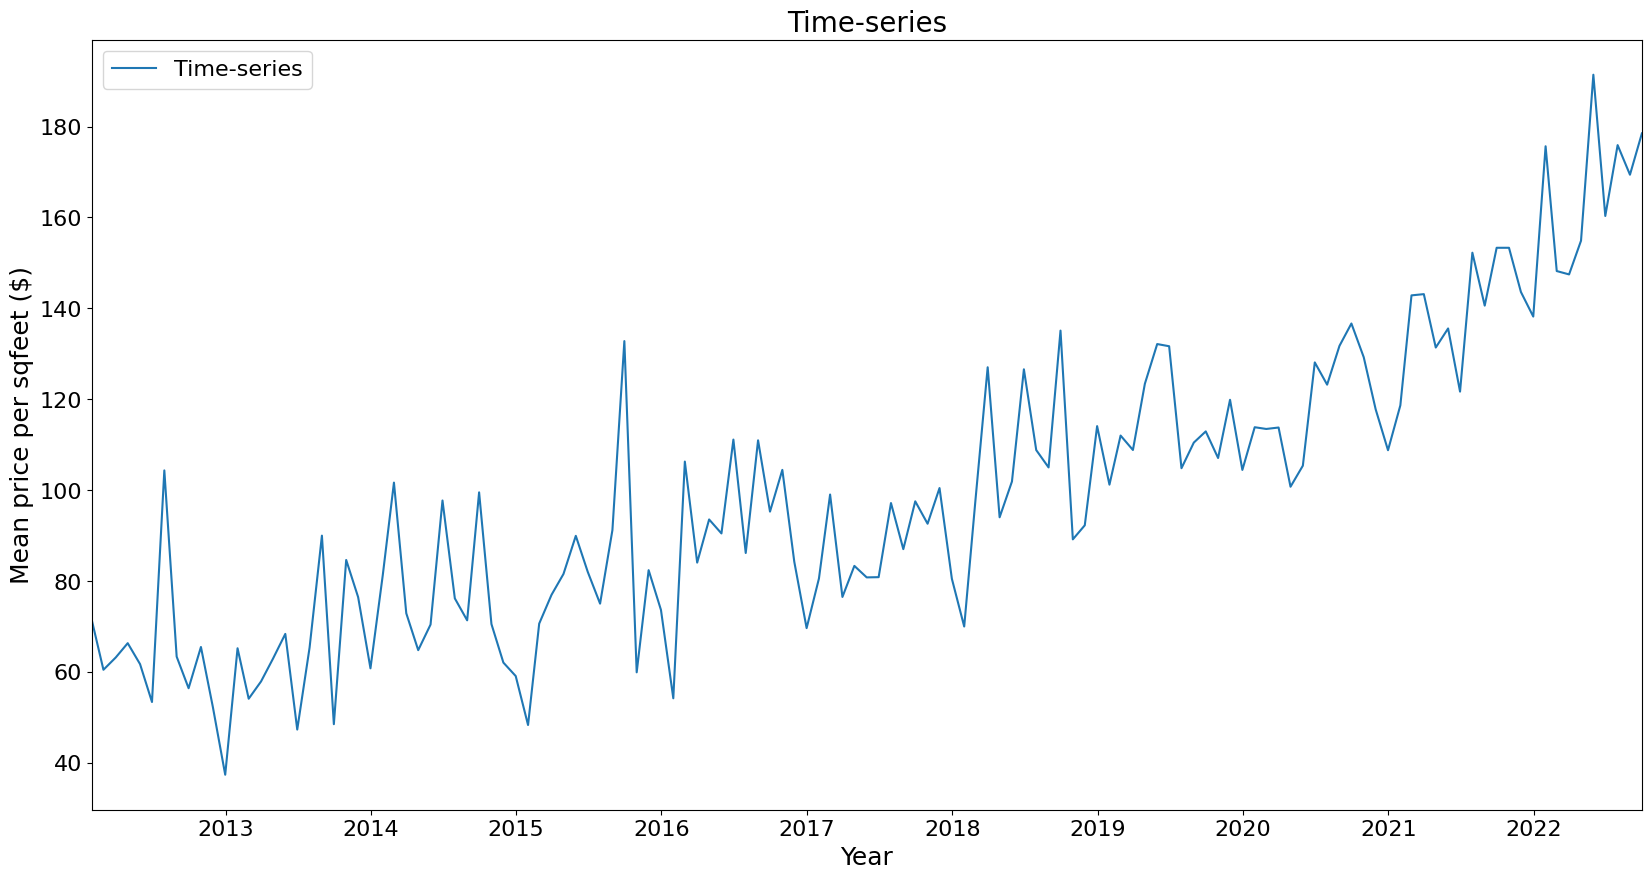

In [118]:
plt.figure(figsize=(20,10))
plt.plot(ts,label='Time-series')
plt.xlim(dates.date2num([ts.index[0], ts.index[-1]]))
plt.xlabel("Year", fontsize='18')
plt.ylabel("Mean price per sqfeet ($)", fontsize='18')
plt.title("Time-series", fontsize='20')

plt.legend(loc='best')
font = {'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.show()

In [119]:
#Train-test split, 20 years of training data and 5 years of test data
ts_train=ts[ts.index[0]:( ts.index[ts.index.get_loc('2019-12-31', method='nearest')])]
ts_test=ts[ ts.index[ts.index.get_loc('2019-12-31', method='nearest')]:ts.index[-1]]
print('ts_test ',ts)

ts_test              median_ppsf
period_end             
2012-01-31    71.269575
2012-02-29    60.443510
2012-03-31    63.160608
2012-04-30    66.298343
2012-05-31    61.686587
...                 ...
2022-05-31   191.427156
2022-06-30   160.335653
2022-07-31   175.932442
2022-08-31   169.416152
2022-09-30   178.516986

[129 rows x 1 columns]


In [120]:
from pmdarima.arima import auto_arima
paramsearch=auto_arima(ts_train,start_p=2,d=None,start_q=1,max_p=7,max_d=1,max_q=5,start_P=1,D=1,start_Q=1,max_P=7,max_D=3,max_Q=7,m=12, trace=True,enforce_stationarity=False)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=724.407, Time=0.81 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=752.333, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=731.301, Time=0.23 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=760.091, Time=0.06 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept   : AIC=734.103, Time=0.41 sec
 ARIMA(2,0,1)(2,1,1)[12] intercept   : AIC=725.756, Time=1.34 sec
 ARIMA(2,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=755.876, Time=0.11 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AIC=724.313, Time=1.16 sec
 ARIMA(2,0,1)(0,1,3)[12] intercept   : AIC=726.410, Time=1.34 sec
 ARIMA(2,0,1)(1,1,3)[12] intercept   : AIC=727.782, Time=2.46 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=722.934, Time=0.75 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=in

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.17534D+00    |proj g|=  3.90641D-02

At iterate    5    f=  4.16331D+00    |proj g|=  9.97922D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      8      1     0     0   9.979D-06   4.163D+00
  F =   4.1633135736494022     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


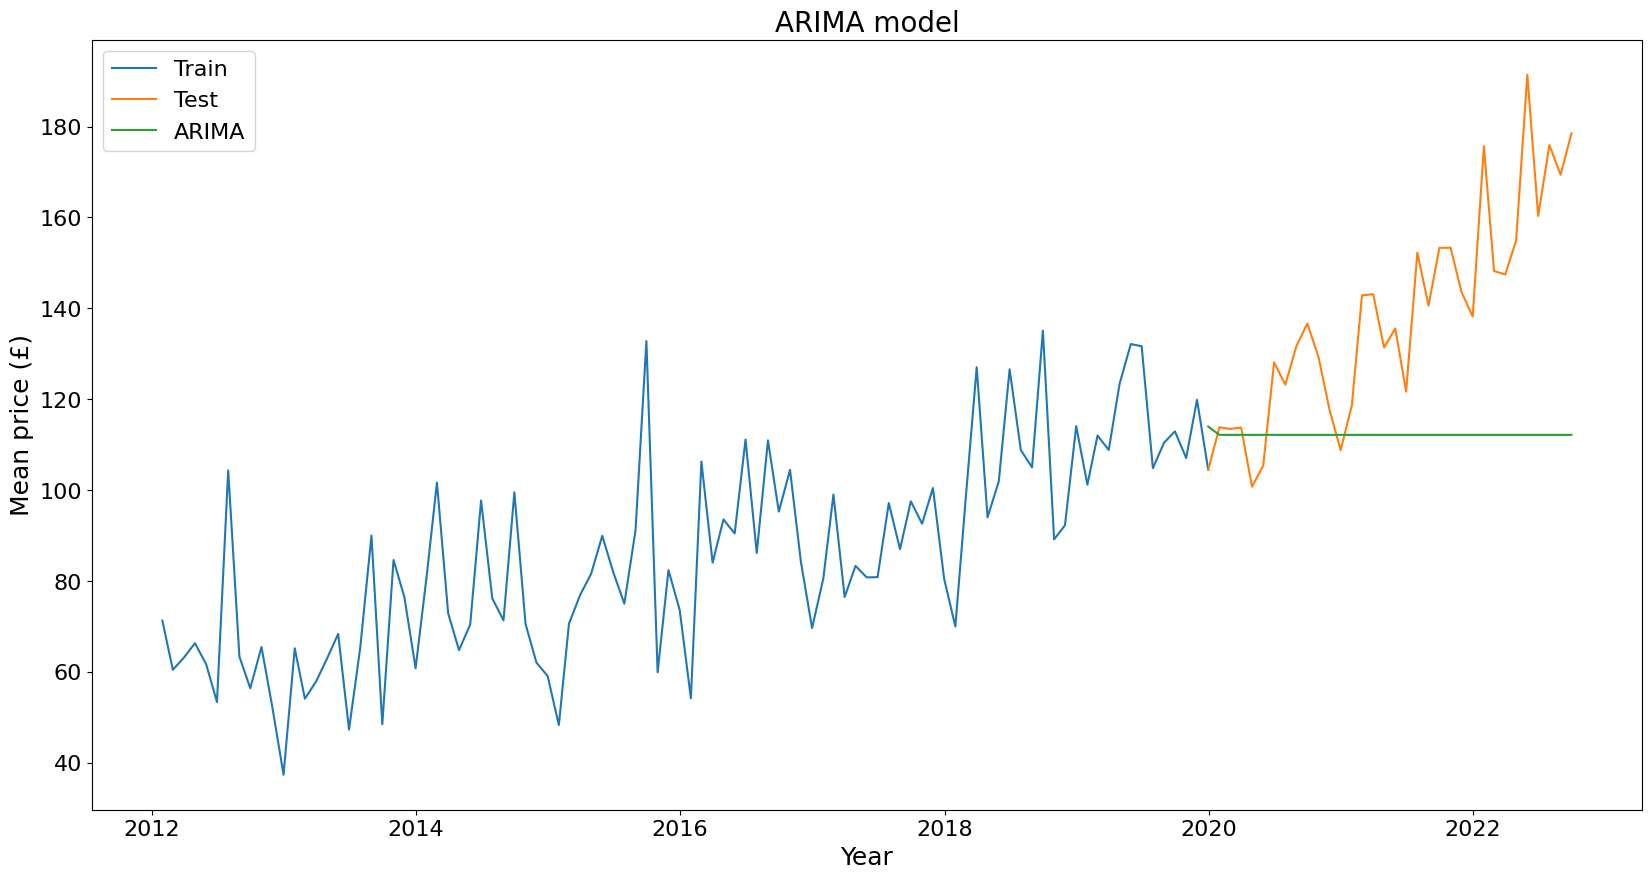

The Root Mean Squared Error of our forecasts is 34.8


In [121]:
#ARIMA
import statsmodels.api as sm
y_hat_avg = ts_test.copy()
fit1 = sm.tsa.statespace.SARIMAX(ts_train, order=(0, 1, 1),freq='m',seasonal_order=(0,0,0,0)).fit()
y_hat_avg['ARIMA'] = fit1.predict(start=ts_test.index[0],end=ts_test.index[-1])
plt.figure(figsize=(20,10))
plt.plot( ts_train, label='Train')
plt.plot(ts_test, label='Test')
plt.plot(y_hat_avg['ARIMA'], label='ARIMA')
plt.xlabel("Year", fontsize='18')
plt.ylabel("Mean price (£)", fontsize='18')
plt.title("ARIMA model", fontsize='20')

plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.legend(loc='best')
plt.show()
rms = np.sqrt(mean_squared_error(ts_test, y_hat_avg.ARIMA))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rms, 1)))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88685D+00    |proj g|=  3.82819D-01


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate    5    f=  3.75372D+00    |proj g|=  3.89177D-02

At iterate   10    f=  3.70254D+00    |proj g|=  6.43254D-03

At iterate   15    f=  3.70048D+00    |proj g|=  1.64931D-03

At iterate   20    f=  3.70046D+00    |proj g|=  5.73654D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     23      1     0     0   7.815D-06   3.700D+00
  F =   3.7004614428614420     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


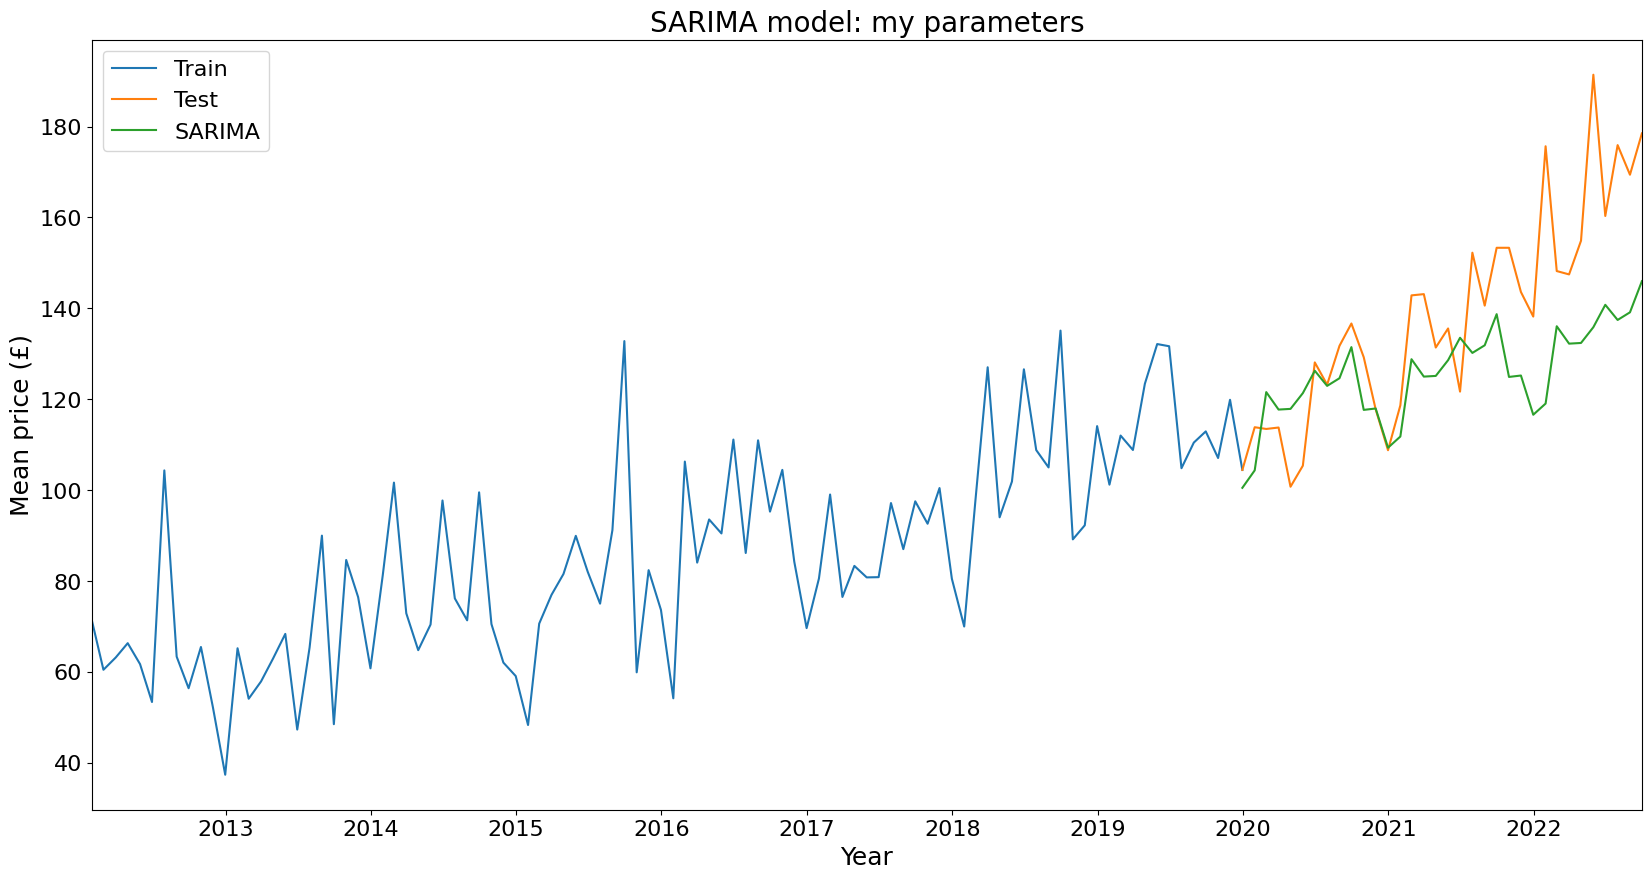

In [122]:
#SARIMA
y_hat_avg1 = ts_test.copy()
fit3 = sm.tsa.statespace.SARIMAX(ts_train, order=(1, 1, 1),seasonal_order=(0,1,1,12)).fit()
y_hat_avg1['SARIMA'] = fit3.predict(start=ts_test.index[0],end=ts_test.index[-1])
plt.figure(figsize=(20,10))
plt.plot( ts_train, label='Train')
plt.plot(ts_test, label='Test')
plt.plot(y_hat_avg1['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.xlabel("Year", fontsize='18')
plt.xlim(dates.date2num([ts_train.index[0], ts_test.index[-1]]))
plt.ylabel("Mean price (£)", fontsize='18')
plt.title("SARIMA model: my parameters", fontsize='20')

plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.show()

In [123]:
rms2 = np.sqrt(mean_squared_error(ts_test, y_hat_avg1.SARIMA))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rms2, 1)))

The Root Mean Squared Error of our forecasts is 21.1


In [124]:
#Creating a test date set of future dates
ts_test_future=ts_test
ts_test_future.index=ts_test_future.index+pd.DateOffset(years=3)

ts_test_future.copy()             median_ppsf
period_end             
2022-12-31   104.434907
2023-01-31   113.834423
2023-02-28   113.453370
2023-03-31   113.769227
2023-04-30   100.735294
2023-05-31   105.368590
2023-06-30   128.100861
2023-07-31   123.204837
2023-08-31   131.740310
2023-09-30   136.666667
2023-10-31   129.241517
2023-11-30   117.768123
2023-12-31   108.773272
2024-01-31   118.648677
2024-02-28   142.857143
2024-03-31   143.129771
2024-04-30   131.377500
2024-05-31   135.576392
2024-06-30   121.675502
2024-07-31   152.247109
2024-08-31   140.600094
2024-09-30   153.333333
2024-10-31   153.333333
2024-11-30   143.601052
2024-12-31   138.193591
2025-01-31   175.679616
2025-02-28   148.210248
2025-03-31   147.471294
2025-04-30   154.891304
2025-05-31   191.427156
2025-06-30   160.335653
2025-07-31   175.932442
2025-08-31   169.416152
2025-09-30   178.516986
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10


 This problem is unconstrained.



At iterate   15    f=  3.78872D+00    |proj g|=  2.47422D-03

At iterate   20    f=  3.78861D+00    |proj g|=  4.46962D-04

At iterate   25    f=  3.78860D+00    |proj g|=  1.34233D-03

At iterate   30    f=  3.78860D+00    |proj g|=  5.16214D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     37      1     0     0   5.162D-06   3.789D+00
  F =   3.7885977440753447     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


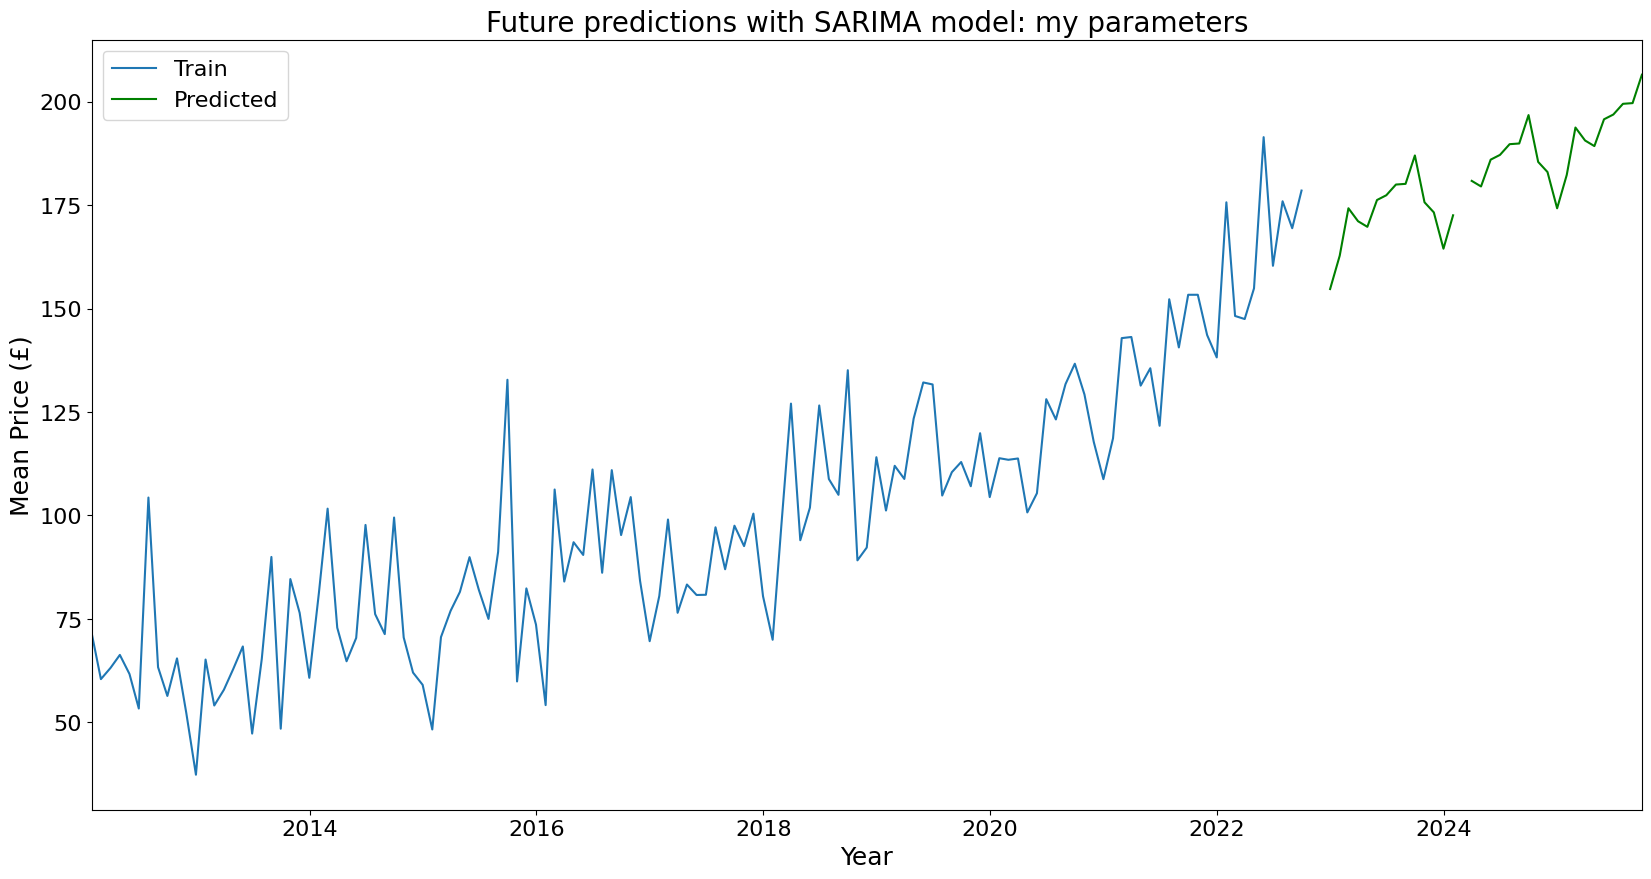

temp_county Hart County, GA
my sarima             median_ppsf      SARIMA
period_end                         
2022-12-31   104.434907  154.715163
2023-01-31   113.834423  162.787566
2023-02-28   113.453370  174.242304
2023-03-31   113.769227  171.105799
2023-04-30   100.735294  169.754583
2023-05-31   105.368590  176.233226
2023-06-30   128.100861  177.383623
2023-07-31   123.204837  179.971943
2023-08-31   131.740310  180.139830
2023-09-30   136.666667  187.003486
2023-10-31   129.241517  175.686126
2023-11-30   117.768123  173.245486
2023-12-31   108.773272  164.474549
2024-01-31   118.648677  172.541703
2024-02-28   142.857143         NaN
2024-03-31   143.129771  180.860617
2024-04-30   131.377500  179.509420
2024-05-31   135.576392  185.988060
2024-06-30   121.675502  187.138457
2024-07-31   152.247109  189.726777
2024-08-31   140.600094  189.894664
2024-09-30   153.333333  196.758320
2024-10-31   153.333333  185.440960
2024-11-30   143.601052  183.000320
2024-12-31   138.193591  1

In [125]:
y_hat_avg_future = ts_test_future.copy()
print('ts_test_future.copy()',y_hat_avg_future)
fit_future = sm.tsa.statespace.SARIMAX(ts, order=(1, 1, 1),seasonal_order=(0,1,1,12)).fit()

y_hat_avg_future['SARIMA'] = fit_future.predict(start=ts_test_future.index[0],end=ts_test_future.index[-1])
plt.figure(figsize=(20,10))
plt.plot( ts, label='Train')
plt.plot(y_hat_avg_future['SARIMA'], label='Predicted', color='g')
plt.legend(loc='best')
plt.xlabel("Year", fontsize='18')
plt.xlim(dates.date2num([ts_train.index[0], ts_test_future.index[-1]]))
plt.ylabel("Mean Price (£)", fontsize='18')
plt.title("Future predictions with SARIMA model: my parameters", fontsize='20')

plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.show()


#Database code to insert predicted data 
print('temp_county',temp_county)
print('my sarima', y_hat_avg_future)


table = client.get_table("{}.{}.{}".format('chain-coders', 'redfin', 'redfin-data-county'))

#bq_client = bigquery.Client()
#table = bq_client.get_table("{}.{}.{}".format(PROJECT, DATASET, TABLE))

rows_to_insert = [{u"period_end":"2022-12-31",u"region": temp_county, u"property_type": "Single Family Residential", u"property_type_id":"6" , u"median_ppsf": 1122.7773}, {u"region": "test124", u"property_type": "SFH", u"median_ppsf": 1133.7773}]

errors = client.insert_rows_json(table, rows_to_insert)
if errors == []:
    print("success")
else:
    print('errors',errors)


In [126]:
#Train-test split, 20 years of training data and 5 years of test data
ts_train=ts[ts.index[0]:( ts.index[ts.index.get_loc('2016-12-31', method='nearest')])]
ts_test=ts[ ts.index[ts.index.get_loc('2016-12-31', method='nearest')]:ts.index[ts.index.get_loc('2019-12-31', method='nearest')]]

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55571D+00    |proj g|=  2.99206D-01

At iterate    5    f=  3.48106D+00    |proj g|=  1.06578D-02

At iterate   10    f=  3.45574D+00    |proj g|=  4.56495D-02

At iterate   15    f=  3.45181D+00    |proj g|=  1.23140D-02

At iterate   20    f=  3.45050D+00    |proj g|=  1.12928D-03

At iterate   25    f=  3.45037D+00    |proj g|=  3.00880D-04

At iterate   30    f=  3.45036D+00    |proj g|=  1.87645D-04

At iterate   35    f=  3.45036D+00    |proj g|=  2.60943D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

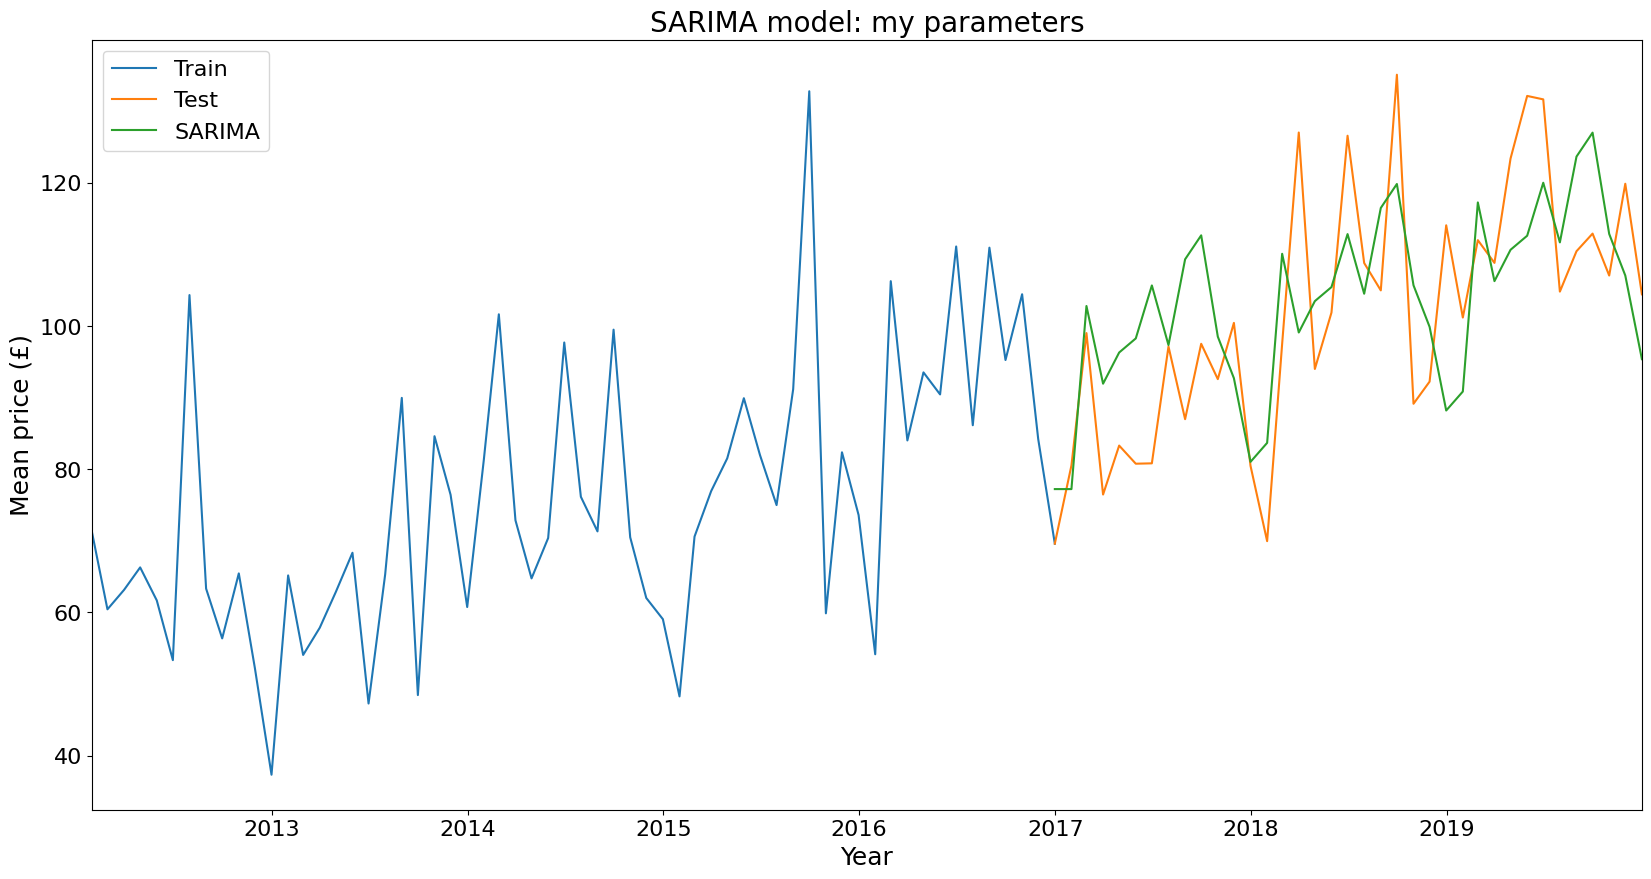

In [127]:
#SARIMA
y_hat_avg1 = ts_test.copy()
fit3 = sm.tsa.statespace.SARIMAX(ts_train, order=(1, 1, 1),seasonal_order=(0,1,1,12)).fit()
y_hat_avg1['SARIMA'] = fit3.predict(start=ts_test.index[0],end=ts_test.index[-1])
plt.figure(figsize=(20,10))
plt.plot( ts_train, label='Train')
plt.plot(ts_test, label='Test')
plt.plot(y_hat_avg1['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.xlabel("Year", fontsize='18')
plt.xlim(dates.date2num([ts_train.index[0], ts_test.index[-1]]))
plt.ylabel("Mean price (£)", fontsize='18')
plt.title("SARIMA model: my parameters", fontsize='20')

plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.show()

In [99]:
rms2 = np.sqrt(mean_squared_error(ts_test, y_hat_avg1.SARIMA))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rms2, 1)))

The Root Mean Squared Error of our forecasts is 13.3
